<a href="https://colab.research.google.com/github/rmnchopra91/gen-ai/blob/main/practice/Demo_2_%7C_Chunking%2C_Embeddings_%26_Semantic_Search_on_Wikipedia_Pages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. <font color='red'> Install and Import Required Libraries </font>



In [ ]:
# Install the wikipediaapi library

!pip install wikipedia-api

In [ ]:
# Import required libraries

import numpy as np
import pandas as pd
import wikipediaapi

## 2. <font color = 'red'> Document Chunking </font>

We will generate embeddings for texts related to various Wikipedia articles. But since you are using large blocks of text, before generating the embeddings, you need to generate the chunks. Let's start with a basic chunking technique, and chunk the text by paragraph.

In [ ]:
# Call the Wikipedia function through a user_agent and specify the language

string = "sementicSearchDemo/1.0 (Raman Chopra;)"
wiki_wiki = wikipediaapi.Wikipedia(user_agent= string, language= 'en')

In [ ]:
# Extract the wikipedia page for the page - " The Shawshank Redemption"

page = wiki_wiki.page("The Shawshank Redemption")

In [ ]:
# Check the entire page's text

page.text

'The Shawshank Redemption is a 1994 American prison drama film written and directed by Frank Darabont, based on the 1982 Stephen King novella Rita Hayworth and Shawshank Redemption. The film tells the story of banker Andy Dufresne (Tim Robbins), who is sentenced to life in Shawshank State Penitentiary for the murders of his wife and her lover, despite his claims of innocence. Over the following two decades, he befriends a fellow prisoner, contraband smuggler Ellis "Red" Redding (Morgan Freeman), and becomes instrumental in a money laundering operation led by the prison warden Samuel Norton (Bob Gunton). William Sadler, Clancy Brown, Gil Bellows, and James Whitmore appear in supporting roles.\nDarabont purchased the film rights to King\'s story in 1987, but development did not begin until five years later, when he wrote the script over an eight-week period. Two weeks after submitting his script to Castle Rock Entertainment, Darabont secured a $25 million budget to produce The Shawshank 

In [ ]:
type(page)

wikipediaapi.WikipediaPage

In [ ]:
page.sections

[Section: Plot (1):
 In early 1947, Portland, Maine, banker Andy Dufresne arrives at Shawshank State Prison to serve two consecutive life sentences for murdering his wife and her lover. He is befriended  by Ellis "Red" Redding, a contraband smuggler serving a life sentence, who procures a rock hammer and a large poster of Rita Hayworth for Andy. Assigned to work in the prison laundry, Andy is frequently raped by prison gang "the Sisters" and their leader, Bogs Diamond. 
 In 1949, Andy overhears the captain of the guards, Byron Hadley, complaining about being taxed on an inheritance and offers to help him shelter the money legally. After an assault by the Sisters nearly kills Andy, Hadley beats and cripples Bogs, who is subsequently transferred to another prison; Andy is not attacked again. Warden Samuel Norton meets Andy and reassigns him to the decrepit prison library to assist elderly inmate Brooks Hatlen, a front to use Andy's financial expertise to manage financial matters for othe

### 2.1 <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [ ]:
# Function to extract and store Wikipedia page information

def process_page(page_title):

    page = wiki_wiki.page(page_title)

    if page.exists():
        page_text = page.text
        chunk_size = 1000  # Set your desired chunk size (in characters)

        text_chunks = split_text_into_chunks(page_text, chunk_size)

        # Create a DataFrame to store the chunks and page title
        data = {'Title': [], 'Chunk Text': []}

        for idx, chunk in enumerate(text_chunks):
            data['Title'].append(page_title)
            data['Chunk Text'].append(chunk)

        return pd.DataFrame(data)

    else:
        print(f"The page '{page_title}' does not exist on Wikipedia.")
        return None

In [ ]:
# Function to split text into fixed-size chunks

def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

#### Chunking for multiple documents
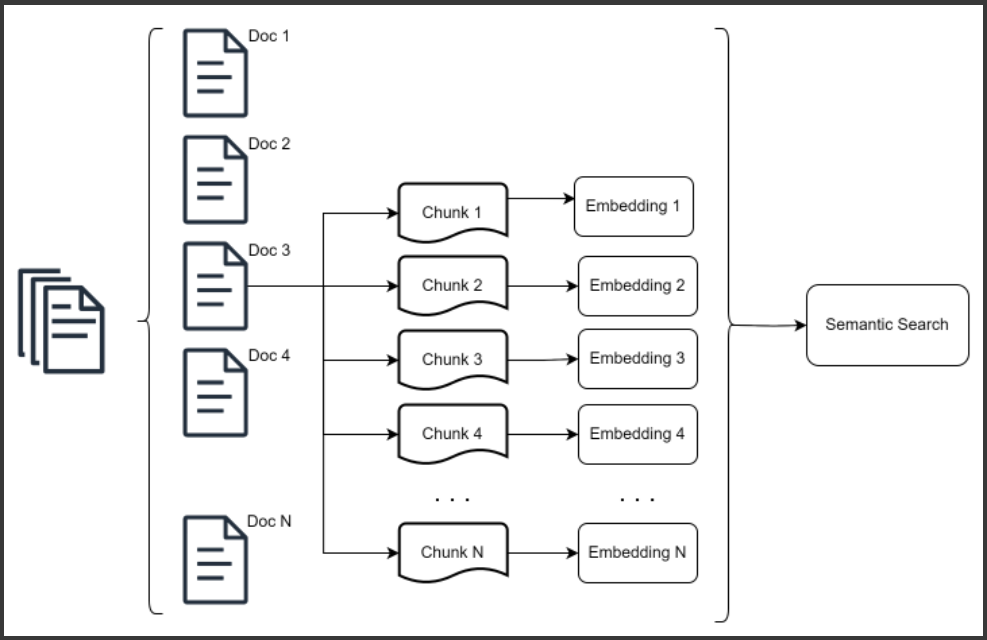

In [ ]:
# Iterating over all page titles to create the final df with individual chunks

page_titles = ["The Shawshank Redemption", "The Dark Knight"]

all_dfs = []

for title in page_titles:
    df = process_page(title)
    if df is not None:
        all_dfs.append(df)


fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,"Redemption, which started pre-production in Ja..."
2,The Shawshank Redemption,It went on to receive multiple award nominatio...
3,The Shawshank Redemption,"National Film Registry, finding it ""culturally..."
4,The Shawshank Redemption,front to use Andy's financial expertise to man...
...,...,...
120,The Dark Knight,"entertainment industry professionals, includin..."
121,The Dark Knight,second-best cinematic superhero performance ev...
122,The Dark Knight,"see yourself become the villain"", as well as P..."
123,The Dark Knight,imposing revolutionary allied with the League ...


### <font color = 'red'>  2.2 Chunking by Paragraph </font>

Here, we will try to chunk and extract individual paragraphs using the newline character.

In [ ]:
# Defining some redundant sections

redundant_sections = [
    "See also",
    "References",
    "External links",
    "Further reading",
    "Footnotes",
    "Bibliography",
    "Sources",
    "Citations",
    "Literature",
    "Footnotes",
    "Notes and references",
    "Photo gallery",
    "Works cited",
    "Photos",
    "Gallery",
    "Notes",
    "References and sources",
    "References and notes",
]

In [ ]:
# Function to extract and store Wikipedia page information

def extract_wikipedia_page(page_title):
    page = wiki_wiki.page(page_title)
    if page.exists():
        title = page.title
        paragraphs = []

        # Extract introduction if available
        if page.summary:
            paragraphs.extend(page.summary.split('\n'))

        # Extract paragraphs from sections
        for section in page.sections:
          if section.title not in redundant_sections:
            extract_paragraphs(section, paragraphs)

        return title, paragraphs

    else:
        return None, None

In [ ]:
# Function to recursively extract paragraphs from sections
def extract_paragraphs(section, accumulated_text):
    accumulated_text.extend(section.text.split('\n'))
    for sub_section in section.sections:
        extract_paragraphs(sub_section, accumulated_text)

In [ ]:
# List of Wikipedia page titles
page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

# Initialize lists to store data
titles = []
paragraphs = []

# Extract data and store in lists
for title in page_titles:
    extracted_title, extracted_paragraphs = extract_wikipedia_page(title)
    if extracted_title and extracted_paragraphs:
        titles.extend([extracted_title] * len(extracted_paragraphs))
        paragraphs.extend(extracted_paragraphs)

# Create a DataFrame
data = {'Title': titles, 'Chunk Text': paragraphs}
para_chunk_df = pd.DataFrame(data)

# Display the DataFrame
para_chunk_df = para_chunk_df[para_chunk_df['Chunk Text'] != '']  # Remove empty paragraphs
para_chunk_df = para_chunk_df.reset_index(drop=True)   # Reset index
para_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Darabont purchased the film rights to King's s...
2,The Shawshank Redemption,While The Shawshank Redemption received critic...
3,The Shawshank Redemption,"Over 320,000 VHS rental copies were shipped th..."
4,The Shawshank Redemption,"In early 1947, Portland, Maine, banker Andy Du..."
...,...,...
237,Goodfellas,AFI's 100 Years... 100 Movies - #94
238,Goodfellas,AFI's 100 Years... 100 Movies (10th Anniversar...
239,Goodfellas,AFI's 10 Top 10 - #2 Gangster film
240,Goodfellas,AFI's 100 Years... 100 Heroes and Villains - T...


### <font color = 'red'>  2.3 Chunking by Sections </font>

Wikipedia already has the page divided into neat sections and subsections. Let's leverage that for chunking.

In [ ]:
# Function to extract and store Wikipedia page sections
def extract_wikipedia_sections(page_title):
    page = wiki_wiki.page(page_title)
    if page.exists():
        title = page.title
        sections = []

        # Extract introduction if available
        introduction = page.summary
        if introduction:
            sections.append(("Introduction", introduction))

        # Extract all sections and subsections recursively
        def recursive_extraction(section):
            section_text = section.text
            if section_text:
                sections.append((section.title, section_text))
            for sub_section in section.sections:
                recursive_extraction(sub_section)

        for section in page.sections:
            if section.title not in redundant_sections:
                recursive_extraction(section)

        return title, sections

    else:
        return None, None

In [ ]:
# List of Wikipedia page titles
page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

# Initialize lists to store data
titles = []
section_titles = []
section_texts = []

# Extract data and store in lists
for title in page_titles:
    extracted_title, extracted_sections = extract_wikipedia_sections(title)
    if extracted_title and extracted_sections:
        for section_title, section_text in extracted_sections:
            titles.append(extracted_title)
            section_titles.append(section_title)
            section_texts.append(section_text)

# Create a DataFrame
data = {'Title': titles, 'Section Title': section_titles, 'Chunk Text': section_texts}
section_chunk_df = pd.DataFrame(data)

# Display the DataFrame
section_chunk_df = section_chunk_df[section_chunk_df['Chunk Text'] != '']  # Remove empty sections
section_chunk_df = section_chunk_df.reset_index(drop=True)  # Reset index
section_chunk_df

,Title,Section Title,Chunk Text
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Plot,"In early 1947, Portland, Maine, banker Andy Du..."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...
4,The Shawshank Redemption,Development,Darabont first collaborated with author Stephe...
...,...,...,...
93,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the..."
94,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...
95,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...
96,Goodfellas,Accolades,It became one of the eight films to win Best P...


In [ ]:
fixed_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,"Redemption, which started pre-production in Ja..."
2,The Shawshank Redemption,It went on to receive multiple award nominatio...
3,The Shawshank Redemption,"National Film Registry, finding it ""culturally..."
4,The Shawshank Redemption,front to use Andy's financial expertise to man...
...,...,...
120,The Dark Knight,"entertainment industry professionals, includin..."
121,The Dark Knight,second-best cinematic superhero performance ev...
122,The Dark Knight,"see yourself become the villain"", as well as P..."
123,The Dark Knight,imposing revolutionary allied with the League ...


In [ ]:
para_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Darabont purchased the film rights to King's s...
2,The Shawshank Redemption,While The Shawshank Redemption received critic...
3,The Shawshank Redemption,"Over 320,000 VHS rental copies were shipped th..."
4,The Shawshank Redemption,"In early 1947, Portland, Maine, banker Andy Du..."
...,...,...
237,Goodfellas,AFI's 100 Years... 100 Movies - #94
238,Goodfellas,AFI's 100 Years... 100 Movies (10th Anniversar...
239,Goodfellas,AFI's 10 Top 10 - #2 Gangster film
240,Goodfellas,AFI's 100 Years... 100 Heroes and Villains - T...


In [ ]:
section_chunk_df

,Title,Section Title,Chunk Text
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Plot,"In early 1947, Portland, Maine, banker Andy Du..."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...
4,The Shawshank Redemption,Development,Darabont first collaborated with author Stephe...
...,...,...,...
93,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the..."
94,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...
95,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...
96,Goodfellas,Accolades,It became one of the eight films to win Best P...


## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline
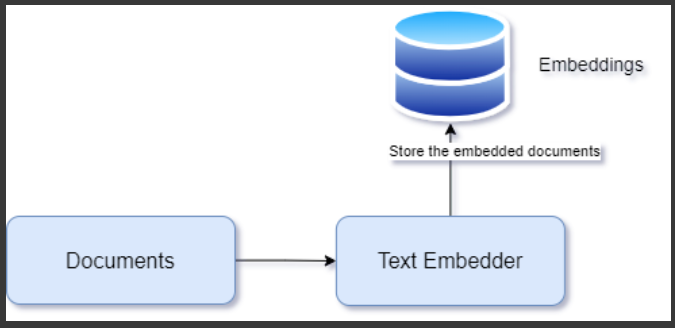

In [ ]:
# Install the sentence transformers library

!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
# Load pre-trained Sentence Transformer model

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=True)
    return embeddings

In [ ]:
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [ ]:
# Create embeddings for 'Chunk Text' column on all three dataframes

generate_embeddings_on_df(fixed_chunk_df)

In [ ]:
generate_embeddings_on_df(para_chunk_df)

In [ ]:
generate_embeddings_on_df(section_chunk_df)

In [ ]:
fixed_chunk_df


,Title,Chunk Text,Embeddings
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...,"[tensor(-0.0475), tensor(-0.0168), tensor(-0.0..."
1,The Shawshank Redemption,"Redemption, which started pre-production in Ja...","[tensor(-0.0266), tensor(-0.0215), tensor(-0.0..."
2,The Shawshank Redemption,It went on to receive multiple award nominatio...,"[tensor(0.0377), tensor(-0.0032), tensor(-0.01..."
3,The Shawshank Redemption,"National Film Registry, finding it ""culturally...","[tensor(-0.0229), tensor(-0.0131), tensor(-0.0..."
4,The Shawshank Redemption,front to use Andy's financial expertise to man...,"[tensor(-0.0076), tensor(-0.0122), tensor(-0.0..."
...,...,...,...
120,The Dark Knight,"entertainment industry professionals, includin...","[tensor(0.0076), tensor(-0.0813), tensor(-0.09..."
121,The Dark Knight,second-best cinematic superhero performance ev...,"[tensor(-0.0875), tensor(-0.0220), tensor(-0.0..."
122,The Dark Knight,"see yourself become the villain"", as well as P...","[tensor(-0.0065), tensor(-0.0630), tensor(-0.1..."
123,The Dark Knight,imposing revolutionary allied with the League ...,"[tensor(-0.0263), tensor(-0.0305), tensor(-0.0..."


In [ ]:
para_chunk_df

,Title,Chunk Text,Embeddings
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...,"[tensor(-0.0596), tensor(-0.0301), tensor(-0.0..."
1,The Shawshank Redemption,Darabont purchased the film rights to King's s...,"[tensor(-0.0404), tensor(-0.0136), tensor(-0.0..."
2,The Shawshank Redemption,While The Shawshank Redemption received critic...,"[tensor(-0.0201), tensor(-0.0309), tensor(-0.0..."
3,The Shawshank Redemption,"Over 320,000 VHS rental copies were shipped th...","[tensor(0.0285), tensor(-0.0182), tensor(-0.01..."
4,The Shawshank Redemption,"In early 1947, Portland, Maine, banker Andy Du...","[tensor(-0.0166), tensor(-0.0001), tensor(-0.0..."
...,...,...,...
237,Goodfellas,AFI's 100 Years... 100 Movies - #94,"[tensor(-0.0367), tensor(-0.0243), tensor(-0.0..."
238,Goodfellas,AFI's 100 Years... 100 Movies (10th Anniversar...,"[tensor(-0.0572), tensor(-0.0156), tensor(0.00..."
239,Goodfellas,AFI's 10 Top 10 - #2 Gangster film,"[tensor(-0.0587), tensor(-0.0536), tensor(-0.0..."
240,Goodfellas,AFI's 100 Years... 100 Heroes and Villains - T...,"[tensor(-0.0658), tensor(0.0377), tensor(-0.08..."


In [ ]:
section_chunk_df

,Title,Section Title,Chunk Text,Embeddings
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...,"[tensor(-0.0452), tensor(-0.0287), tensor(-0.0..."
1,The Shawshank Redemption,Plot,"In early 1947, Portland, Maine, banker Andy Du...","[tensor(0.0048), tensor(0.0036), tensor(-0.048..."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...,"[tensor(-0.0535), tensor(-0.0538), tensor(-0.1..."
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...,"[tensor(-0.0556), tensor(0.0511), tensor(-0.08..."
4,The Shawshank Redemption,Development,Darabont first collaborated with author Stephe...,"[tensor(-0.0338), tensor(-0.0343), tensor(-0.0..."
...,...,...,...,...
93,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the...","[tensor(0.0283), tensor(-0.0623), tensor(-0.01..."
94,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...,"[tensor(-0.0106), tensor(-0.0307), tensor(-0.1..."
95,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...,"[tensor(-0.0047), tensor(-0.0954), tensor(-0.0..."
96,Goodfellas,Accolades,It became one of the eight films to win Best P...,"[tensor(-0.0066), tensor(-0.0777), tensor(-0.0..."


In [ ]:
fixed_chunk_df['Embeddings'][0]

tensor([-4.7502e-02, -1.6763e-02, -9.3447e-02,  2.0531e-02, -4.7562e-02,
         5.7397e-02,  7.2223e-02,  4.3987e-03,  1.3269e-01, -2.9454e-02,
        -7.9937e-02,  3.5719e-02,  6.8437e-02,  2.8048e-02, -3.4025e-02,
         8.6351e-03, -8.3322e-03,  3.9241e-02,  2.8893e-04, -7.3305e-03,
         4.3731e-02, -7.0875e-03,  2.9221e-02, -2.1075e-02, -5.8103e-02,
        -4.9709e-02,  2.3673e-02, -7.1411e-02, -9.2860e-02,  5.6789e-02,
        -7.4944e-03, -6.5762e-02, -5.2410e-03, -2.2328e-02,  2.5844e-03,
         9.6544e-02,  3.8629e-02, -9.5677e-03, -1.1512e-03, -4.6502e-03,
        -2.8632e-03,  2.8166e-02,  4.2735e-02,  4.6888e-02,  7.6699e-02,
        -6.4977e-02, -2.2065e-02, -8.0963e-02,  5.5341e-03, -1.0271e-01,
        -2.5153e-02,  1.1705e-01, -6.6085e-03,  2.2962e-02,  5.9156e-03,
        -5.7109e-02, -4.3696e-03, -1.0061e-03,  1.2190e-02, -7.7765e-02,
        -3.4040e-02,  7.5569e-03,  2.1668e-02, -1.4980e-02,  7.4960e-02,
         1.0036e-02,  1.6717e-02, -5.2320e-03,  2.5

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Save the embeddings in a CSV

output_path = './'


# Save the dataframe with embeddings
fixed_chunk_df.to_csv(output_path+"fixed_chunk_embeddings.csv", index=False)
para_chunk_df.to_csv(output_path+"para_chunk_embeddings.csv", index=False)
section_chunk_df.to_csv(output_path+"section_chunk_embeddings.csv", index=False)

# 4. <font color = 'red'> Building the Semantic Search </font>


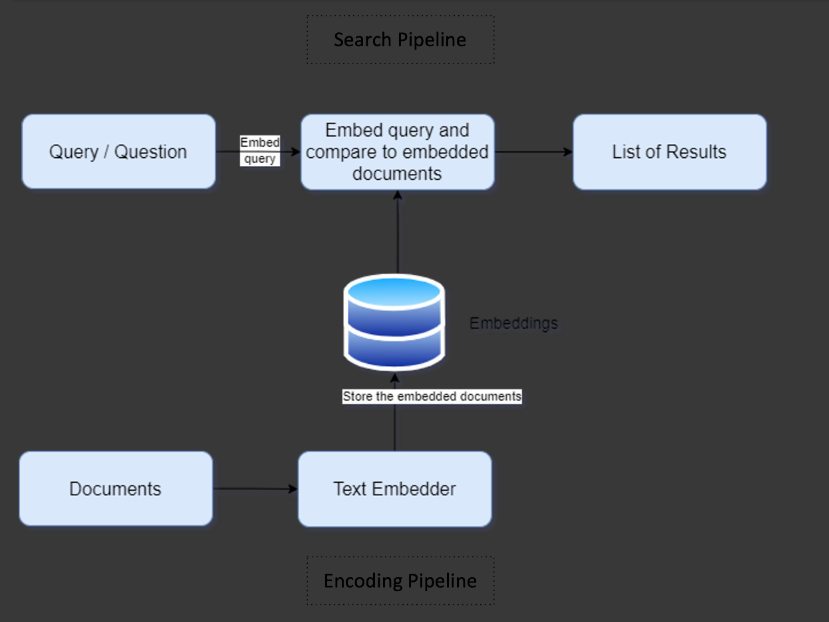

In [ ]:
# Read user input query
user_query = input()

Who was lear hero in dark nights


In [ ]:
# Define the function for calculating cosine similarity

def calculate_similarity(embedding1, embedding2):
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2)
    # Convert the result to a Python float
    similarity = cosine_score.item()

    return similarity

In [ ]:
# Function to perform semantic search and return ranked chunks
def semantic_search(user_query, df, embedder):

    # Calculate the query embedding
    query_embedding = embedder.encode(user_query, convert_to_tensor=True)

    # Calculate similarity scores between the query embedding and all chunk embeddings
    df['Similarity'] = df['Embeddings'].apply(lambda x: calculate_similarity(query_embedding, x))

    # Sort the DataFrame by similarity scores in descending order
    df = df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

    # Return only the top 3 values from the dataframe, and drop the embeddings column for a cleaner view of the final results
    df = df.head(3)
    df.drop('Embeddings', axis = 1, inplace=True)

    return df

In [ ]:
# Perform semantic search on each DataFrame
fixed_chunk_results = semantic_search(user_query, fixed_chunk_df, embedder)
para_chunk_results = semantic_search(user_query, para_chunk_df, embedder)
section_chunk_results = semantic_search(user_query, section_chunk_df, embedder)

In [ ]:
fixed_chunk_results

,Title,Chunk Text,Similarity
0,The Dark Knight,Manohla Dargis praised the depiction of the ch...,0.360375
1,The Dark Knight,continuation of what made The Dark Knight a su...,0.340552
2,The Dark Knight,imposing revolutionary allied with the League ...,0.339243


In [ ]:
para_chunk_results

,Title,Chunk Text,Similarity
0,The Dark Knight,Morgan Freeman as Lucius Fox: Wayne Enterprise...,0.355485
1,The Shawshank Redemption,Clancy Brown as Byron Hadley: The brutal capta...,0.346443
2,The Dark Knight,The Dark Knight is a 2008 superhero film direc...,0.324966


In [ ]:
section_chunk_results

,Title,Section Title,Chunk Text,Similarity
0,The Dark Knight,Critical response,The Dark Knight received critical acclaim. On ...,0.316496
1,The Dark Knight,Introduction,The Dark Knight is a 2008 superhero film direc...,0.293968
2,The Dark Knight,Sequel,The Dark Knight was followed by The Dark Knigh...,0.291072


In [ ]:
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=53b6d7723dc082cca0c7f424549dbaca4975558887c4a139a702a4d988ec3a29
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import plotly.express as px
import umap

# Vector Databases & Retrieval Augmented Generation

In this session, you will learn about vector databases such as ChromaDB and augment the capabilities of a semantic search application with vector database.


## 1. <font color = red> Importing the Required Libraries and the Embeddings </font>

In [ ]:
# Import required libraries

import numpy as np
import pandas as pd
import ast

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# input_path = '/content/drive/My Drive/HelpMate AI Codes/'

In [ ]:
section_chunk_embeddings = pd.read_csv('section_chunk_embeddings.csv')

In [ ]:
section_chunk_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          98 non-null     object
 1   Section Title  98 non-null     object
 2   Chunk Text     98 non-null     object
 3   Embeddings     98 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


### Data preprocessing

In [ ]:
section_chunk_embeddings['Embeddings'] = section_chunk_embeddings['Embeddings'].apply(lambda x: x[7:][:-1])

In [ ]:
section_chunk_embeddings['Embeddings'][0]

'[-4.5234e-02, -2.8654e-02, -8.4308e-02,  2.5436e-02, -3.5023e-02,\n         4.6069e-02,  6.7365e-02, -5.0723e-03,  1.2327e-01, -2.2020e-02,\n        -7.0932e-02,  4.1421e-02,  7.1477e-02,  4.5033e-02, -3.5538e-02,\n         9.7735e-03,  1.2935e-02,  2.5428e-02, -7.0864e-03,  7.6964e-03,\n         5.1681e-02, -1.6334e-02,  3.5429e-02, -3.3055e-02, -4.9527e-02,\n        -3.3702e-02,  1.6654e-02, -7.6722e-02, -8.4791e-02,  6.0315e-02,\n        -1.9919e-02, -7.8969e-02, -2.5472e-02, -1.9788e-02,  8.9350e-03,\n         8.0604e-02,  4.3905e-02, -1.0023e-02, -1.0294e-02, -1.2882e-03,\n        -1.4940e-02,  4.8730e-02,  4.0125e-02,  4.1119e-02,  5.5447e-02,\n        -6.6756e-02, -1.5770e-02, -8.0316e-02,  4.1568e-04, -1.0977e-01,\n        -3.1936e-02,  1.1492e-01, -1.9863e-02,  2.5466e-02, -1.9720e-03,\n        -6.6851e-02, -8.9303e-03,  3.7322e-03, -6.4495e-03, -6.6111e-02,\n        -4.6566e-02,  4.1288e-03,  1.5850e-02, -1.3968e-02,  7.4380e-02,\n         1.9631e-02,  8.9285e-03, -1.1776e-0

In [ ]:
section_chunk_embeddings['Embeddings'] = section_chunk_embeddings['Embeddings'].apply(lambda x: ast.literal_eval(x))

In [ ]:
section_chunk_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          98 non-null     object
 1   Section Title  98 non-null     object
 2   Chunk Text     98 non-null     object
 3   Embeddings     98 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


In [ ]:
section_chunk_embeddings

,Title,Section Title,Chunk Text,Embeddings
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...,"[-0.045234, -0.028654, -0.084308, 0.025436, -0..."
1,The Shawshank Redemption,Plot,"In early 1947, Portland, Maine, banker Andy Du...","[0.004824, 0.003594, -0.048157, -0.020392, -0...."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...,"[-0.053459, -0.053774, -0.12491, -0.012516, -0..."
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...,"[-0.055615, 0.051125, -0.083388, -0.0088534, -..."
4,The Shawshank Redemption,Development,Darabont first collaborated with author Stephe...,"[-0.033833, -0.034259, -0.022021, 0.083097, -0..."
...,...,...,...,...
93,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the...","[0.028257, -0.062327, -0.015942, 0.078449, -0...."
94,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...,"[-0.010567, -0.030689, -0.12178, 0.024075, 0.0..."
95,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...,"[-0.0047438, -0.095356, -0.063817, 0.019216, 0..."
96,Goodfellas,Accolades,It became one of the eight films to win Best P...,"[-0.0066345, -0.07772, -0.01668, 9.9736e-05, 0..."


In [ ]:
section_chunk_embeddings['Embeddings'][0]

[-0.045234,
 -0.028654,
 -0.084308,
 0.025436,
 -0.035023,
 0.046069,
 0.067365,
 -0.0050723,
 0.12327,
 -0.02202,
 -0.070932,
 0.041421,
 0.071477,
 0.045033,
 -0.035538,
 0.0097735,
 0.012935,
 0.025428,
 -0.0070864,
 0.0076964,
 0.051681,
 -0.016334,
 0.035429,
 -0.033055,
 -0.049527,
 -0.033702,
 0.016654,
 -0.076722,
 -0.084791,
 0.060315,
 -0.019919,
 -0.078969,
 -0.025472,
 -0.019788,
 0.008935,
 0.080604,
 0.043905,
 -0.010023,
 -0.010294,
 -0.0012882,
 -0.01494,
 0.04873,
 0.040125,
 0.041119,
 0.055447,
 -0.066756,
 -0.01577,
 -0.080316,
 0.00041568,
 -0.10977,
 -0.031936,
 0.11492,
 -0.019863,
 0.025466,
 -0.001972,
 -0.066851,
 -0.0089303,
 0.0037322,
 -0.0064495,
 -0.066111,
 -0.046566,
 0.0041288,
 0.01585,
 -0.013968,
 0.07438,
 0.019631,
 0.0089285,
 -0.011776,
 0.040015,
 -0.06704,
 -0.079944,
 0.039827,
 -0.011427,
 -0.071061,
 -0.061366,
 -0.079808,
 0.02758,
 0.12659,
 -0.046352,
 -0.096243,
 -0.016517,
 -0.094117,
 0.03203,
 0.10306,
 -0.020143,
 0.093839,
 -0.0402

In [ ]:
type(section_chunk_embeddings['Embeddings'][0])

list

## 2. <font color = red> ChromaDB </font>

### <font color = red> 2.1 Adding documents/embeddings to ChromaDB and working with Collections </font>

You can add embeddings or chunks of text directly to chroma using their collection methods.

* **`.create_collection()`**
* **`.list_collections()`**
* **`.delete_collections()`**








In [ ]:
# Pip install chromaDB

!pip install chromaDB

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 

In [ ]:
# Import ChromaDB and get the Chroma client

import chromadb
# chroma_client = chromadb.PersistentClient(path="./")
chroma_client = chromadb.PersistentClient()

In [ ]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.

collection = chroma_client.get_or_create_collection(name="Semantic_Search_with_Chromadb")

In [ ]:
# Add the documents, embeddings, and ids into the collection

collection.add(
    embeddings = section_chunk_embeddings['Embeddings'].to_list(),
    documents = section_chunk_embeddings['Chunk Text'].to_list(),
    ids = [str(i) for i in range(0, len(section_chunk_embeddings['Embeddings']))],
)

In [ ]:
# Peek at the initial elements of the collection

collection.peek()

{'ids': ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'],
 'embeddings': [[-0.045234,
   -0.028654,
   -0.084308,
   0.025436,
   -0.035023,
   0.046069,
   0.067365,
   -0.0050723,
   0.12327,
   -0.02202,
   -0.070932,
   0.041421,
   0.071477,
   0.045033,
   -0.035538,
   0.0097735,
   0.012935,
   0.025428,
   -0.0070864,
   0.0076964,
   0.051681,
   -0.016334,
   0.035429,
   -0.033055,
   -0.049527,
   -0.033702,
   0.016654,
   -0.076722,
   -0.084791,
   0.060315,
   -0.019919,
   -0.078969,
   -0.025472,
   -0.019788,
   0.008935,
   0.080604,
   0.043905,
   -0.010023,
   -0.010294,
   -0.0012882,
   -0.01494,
   0.04873,
   0.040125,
   0.041119,
   0.055447,
   -0.066756,
   -0.01577,
   -0.080316,
   0.00041568,
   -0.10977,
   -0.031936,
   0.11492,
   -0.019863,
   0.025466,
   -0.001972,
   -0.066851,
   -0.0089303,
   0.0037322,
   -0.0064495,
   -0.066111,
   -0.046566,
   0.0041288,
   0.01585,
   -0.013968,
   0.07438,
   0.019631,
   0.0089285,
   -0.01

In [ ]:
# Retrieve items from the collection

collection.get(
    ids = ['0','1']
)

{'ids': ['0', '1'],
 'embeddings': None,
 'metadatas': [None, None],
 'documents': ['The Shawshank Redemption is a 1994 American prison drama film written and directed by Frank Darabont, based on the 1982 Stephen King novella Rita Hayworth and Shawshank Redemption. The film tells the story of banker Andy Dufresne (Tim Robbins), who is sentenced to life in Shawshank State Penitentiary for the murders of his wife and her lover, despite his claims of innocence. Over the following two decades, he befriends a fellow prisoner, contraband smuggler Ellis "Red" Redding (Morgan Freeman), and becomes instrumental in a money laundering operation led by the prison warden Samuel Norton (Bob Gunton). William Sadler, Clancy Brown, Gil Bellows, and James Whitmore appear in supporting roles.\nDarabont purchased the film rights to King\'s story in 1987, but development did not begin until five years later, when he wrote the script over an eight-week period. Two weeks after submitting his script to Castle

In [ ]:
# List all the collection created

chroma_client.list_collections()

[Collection(name=Semantic_Search_with_Chromadb)]

In [ ]:
# Delete a collection

# chroma_client.delete_collection("Temporary")

### <font color = red> 2.2 Querying on ChromaDB </font>

* **`collection.query()`**

In [ ]:
# Read the query from the user
query = input()

# Query the ChromaDB collection using `collection.query()
results = collection.query(
    query_texts=query,
    n_results=3,
    include = ['documents', 'distances']
)

who was the director of the dark knight


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 43.8MiB/s]


In [ ]:
# Encode query using Sentence Transformer model

# model_name = "all-MiniLM-L6-v2"
# embedder = SentenceTransformer(model_name)
# query_embedding = embedder.encode(query)

In [ ]:
# See the results

results

{'ids': [['16', '39', '37']],
 'distances': [[0.634729300624357, 0.643862110536054, 0.685135403600041]],
 'metadatas': None,
 'embeddings': None,
 'documents': [['The Dark Knight is a 2008 superhero film directed by Christopher Nolan from a screenplay co-written with his brother Jonathan. Based on the DC Comics superhero Batman, it is the sequel to Batman Begins (2005) and the second installment in The Dark Knight Trilogy. The plot follows the vigilante Batman, police lieutenant James Gordon, and district attorney Harvey Dent, who form an alliance to dismantle organized crime in Gotham City. Their efforts are derailed by the Joker, an anarchistic mastermind who seeks to test how far Batman will go to save the city from chaos. The ensemble cast includes Christian Bale, Michael Caine, Heath Ledger, Gary Oldman, Aaron Eckhart, Maggie Gyllenhaal, and Morgan Freeman.\nWarner Bros. Pictures prioritized a sequel following the successful reinvention of the Batman film series with Batman Begins

In [ ]:
# Format the results to return in a more structured and readable form

data = {'Document': results['documents'][0], 'Distance': results['distances'][0]}
results_df = pd.DataFrame.from_dict(data)
results_df

,Document,Distance
0,The Dark Knight is a 2008 superhero film direc...,0.634729
1,The Dark Knight was followed by The Dark Knigh...,0.643862
2,The Dark Knight is considered an influential a...,0.685135


### 1.3 <font color = red> Updating Collections </font>

* **`collection.update()`**
* **`collection.upsert()`**


In [ ]:
# Converting all text chunks to lowercase

section_chunk_embeddings['Chunk Text'] = section_chunk_embeddings['Chunk Text'].apply(lambda x: x.lower())

In [ ]:
# Adding a metadata column containing the title of the page and the section name

section_chunk_embeddings['Metadata'] = section_chunk_embeddings.apply(lambda x: {'Title': x['Title'], 'Section': x["Section Title"]}, axis=1)

In [ ]:
section_chunk_embeddings

,Title,Section Title,Chunk Text,Embeddings,Metadata
0,The Shawshank Redemption,Introduction,the shawshank redemption is a 1994 american pr...,"[-0.045234, -0.028654, -0.084308, 0.025436, -0...","{'Title': 'The Shawshank Redemption', 'Section..."
1,The Shawshank Redemption,Plot,"in early 1947, portland, maine, banker andy du...","[0.004824, 0.003594, -0.048157, -0.020392, -0....","{'Title': 'The Shawshank Redemption', 'Section..."
2,The Shawshank Redemption,Cast,tim robbins as andy dufresne: a banker sentenc...,"[-0.053459, -0.053774, -0.12491, -0.012516, -0...","{'Title': 'The Shawshank Redemption', 'Section..."
3,The Shawshank Redemption,Analysis,the film has been interpreted as being grounde...,"[-0.055615, 0.051125, -0.083388, -0.0088534, -...","{'Title': 'The Shawshank Redemption', 'Section..."
4,The Shawshank Redemption,Development,darabont first collaborated with author stephe...,"[-0.033833, -0.034259, -0.022021, 0.083097, -0...","{'Title': 'The Shawshank Redemption', 'Section..."
...,...,...,...,...,...
93,Goodfellas,Box office,"goodfellas grossed $6.3 million from 1,070 the...","[0.028257, -0.062327, -0.015942, 0.078449, -0....","{'Title': 'Goodfellas', 'Section': 'Box office'}"
94,Goodfellas,Critical response,according to review aggregator rotten tomatoes...,"[-0.010567, -0.030689, -0.12178, 0.024075, 0.0...","{'Title': 'Goodfellas', 'Section': 'Critical r..."
95,Goodfellas,Lists,the film was ranked the best of 1990 by roger ...,"[-0.0047438, -0.095356, -0.063817, 0.019216, 0...","{'Title': 'Goodfellas', 'Section': 'Lists'}"
96,Goodfellas,Accolades,it became one of the eight films to win best p...,"[-0.0066345, -0.07772, -0.01668, 9.9736e-05, 0...","{'Title': 'Goodfellas', 'Section': 'Accolades'}"


In [ ]:
# Convert the metadata column to a list to feed it to ChromaDB

metadata_list = section_chunk_embeddings['Metadata'].tolist()

In [ ]:
# Update the collection using `collection.upsert()`

collection.upsert(
    embeddings = section_chunk_embeddings['Embeddings'].to_list(),
    documents = section_chunk_embeddings['Chunk Text'].to_list(),

    metadatas = metadata_list,
    ids = [str(i) for i in range(0, len(section_chunk_embeddings['Embeddings']))],
)

In [ ]:
collection.peek()

{'ids': ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'],
 'embeddings': [[-0.045234,
   -0.028654,
   -0.084308,
   0.025436,
   -0.035023,
   0.046069,
   0.067365,
   -0.0050723,
   0.12327,
   -0.02202,
   -0.070932,
   0.041421,
   0.071477,
   0.045033,
   -0.035538,
   0.0097735,
   0.012935,
   0.025428,
   -0.0070864,
   0.0076964,
   0.051681,
   -0.016334,
   0.035429,
   -0.033055,
   -0.049527,
   -0.033702,
   0.016654,
   -0.076722,
   -0.084791,
   0.060315,
   -0.019919,
   -0.078969,
   -0.025472,
   -0.019788,
   0.008935,
   0.080604,
   0.043905,
   -0.010023,
   -0.010294,
   -0.0012882,
   -0.01494,
   0.04873,
   0.040125,
   0.041119,
   0.055447,
   -0.066756,
   -0.01577,
   -0.080316,
   0.00041568,
   -0.10977,
   -0.031936,
   0.11492,
   -0.019863,
   0.025466,
   -0.001972,
   -0.066851,
   -0.0089303,
   0.0037322,
   -0.0064495,
   -0.066111,
   -0.046566,
   0.0041288,
   0.01585,
   -0.013968,
   0.07438,
   0.019631,
   0.0089285,
   -0.01

In [ ]:
collection.get(
    ids = ['0','1']
)

{'ids': ['0', '1'],
 'embeddings': None,
 'metadatas': [{'Section': 'Introduction',
   'Title': 'The Shawshank Redemption'},
  {'Section': 'Plot', 'Title': 'The Shawshank Redemption'}],
 'documents': ['the shawshank redemption is a 1994 american prison drama film written and directed by frank darabont, based on the 1982 stephen king novella rita hayworth and shawshank redemption. the film tells the story of banker andy dufresne (tim robbins), who is sentenced to life in shawshank state penitentiary for the murders of his wife and her lover, despite his claims of innocence. over the following two decades, he befriends a fellow prisoner, contraband smuggler ellis "red" redding (morgan freeman), and becomes instrumental in a money laundering operation led by the prison warden samuel norton (bob gunton). william sadler, clancy brown, gil bellows, and james whitmore appear in supporting roles.\ndarabont purchased the film rights to king\'s story in 1987, but development did not begin until 

In [ ]:
# Query on the collection again, this time with filters on the chunk texts and the metadata

query = input()

results = collection.query(
    query_texts=query,
    n_results=3,
    where = {'Section': 'Critical response'},
    where_document = {"$or" : [{"$contains": "positive"}, {"$contains": "review"}]},
    include = ['documents', 'distances']
)

was the movie the shawshank redemption positively received?


In [ ]:
results

{'ids': [['11', '52', '94']],
 'distances': [[0.9418264109513869, 1.2503703981328442, 1.2952020176349976]],
 'metadatas': None,
 'embeddings': None,
 'documents': [['the shawshank redemption opened to generally positive reviews. some reviewers compared the film to other well-received prison dramas, including birdman of alcatraz, cool hand luke, and riot in cell block 11. gene siskel said that, like one flew over the cuckoo\'s nest, the shawshank redemption is an inspirational drama about overcoming overbearing authority. audiences polled by cinemascore gave the film an average grade of "a" on an a+ to f scale.entertainment weekly\'s owen gleiberman said that freeman makes the red character feel genuine and "lived-in". janet maslin of the new york times said that freeman was quietly impressive, but lamented that red\'s role in the film had limited range, restricted to observing andy. she considered freeman\'s commanding performance made him a much stronger figure than simply an observer

In [ ]:
data = {'Column1': results['documents'][0], 'Column2': results['distances'][0]}
results_df = pd.DataFrame.from_dict(data)
results_df

,Column1,Column2
0,the shawshank redemption opened to generally p...,0.941826
1,"on review aggregator rotten tomatoes, the film...",1.250370
2,according to review aggregator rotten tomatoes...,1.295202


# How to store collections in drive and load them later on

In [ ]:
import chromadb
client = chromadb.Client()

In [ ]:
#use the persistantClient method to persist data to your disk

chroma_client = chromadb.PersistentClient(path="./")

In [ ]:
# create a collection to store embeddings, Collections in chroma are where you can store your embeddings, documents, and any additional metadata

collection = chroma_client.create_collection(name="Sementic_Search_With_Chromadb")

In [ ]:
# Add the document embeddings and ids into them

collection.add(
    embeddings = section_chunk_embeddings['Embeddings'].to_list(),
    documents = section_chunk_embeddings['Chunk Text'].to_list(),
    ids=[str(i) for i in range(0, len(section_chunk_embeddings['Embeddings']))],
)

In [ ]:
# Peak at the initiall element of the collection
collection.peek()

{'ids': ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'],
 'embeddings': [[-0.045234,
   -0.028654,
   -0.084308,
   0.025436,
   -0.035023,
   0.046069,
   0.067365,
   -0.0050723,
   0.12327,
   -0.02202,
   -0.070932,
   0.041421,
   0.071477,
   0.045033,
   -0.035538,
   0.0097735,
   0.012935,
   0.025428,
   -0.0070864,
   0.0076964,
   0.051681,
   -0.016334,
   0.035429,
   -0.033055,
   -0.049527,
   -0.033702,
   0.016654,
   -0.076722,
   -0.084791,
   0.060315,
   -0.019919,
   -0.078969,
   -0.025472,
   -0.019788,
   0.008935,
   0.080604,
   0.043905,
   -0.010023,
   -0.010294,
   -0.0012882,
   -0.01494,
   0.04873,
   0.040125,
   0.041119,
   0.055447,
   -0.066756,
   -0.01577,
   -0.080316,
   0.00041568,
   -0.10977,
   -0.031936,
   0.11492,
   -0.019863,
   0.025466,
   -0.001972,
   -0.066851,
   -0.0089303,
   0.0037322,
   -0.0064495,
   -0.066111,
   -0.046566,
   0.0041288,
   0.01585,
   -0.013968,
   0.07438,
   0.019631,
   0.0089285,
   -0.01

In [ ]:
# all_results

In [ ]:
# # Combine all results into a single DataFrame for visualization
# all_results = pd.concat([fixed_chunk_results, para_chunk_results, section_chunk_results], ignore_index=True)

# # Assuming 'Embeddings' is the column containing embeddings as PyTorch tensors
# embeddings = all_results['Embeddings'].tolist()

# # Convert PyTorch tensors to NumPy arrays
# embeddings = [embedding.cpu().numpy() if hasattr(embedding, 'cpu') else embedding.numpy() for embedding in embeddings]

# # Convert the list of embeddings into a 2D NumPy array
# X = np.array(embeddings)

# # Reduce dimensionality using UMAP
# umap_model = umap.UMAP(n_components=2)
# umap_embeddings = umap_model.fit_transform(X)

# # Add UMAP embeddings as new columns in your dataframe
# all_results['umap_x'] = umap_embeddings[:, 0]
# all_results['umap_y'] = umap_embeddings[:, 1]

In [ ]:
# print(all_results['Embeddings'].apply(lambda x: len(x)).unique())

In [ ]:
# # Visualize the UMAP embeddings using Plotly
# fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['Page Title', 'Chunk Text'])
# fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
# fig.show()

In [ ]:
# # Compute the user query embedding (replace this with your actual query)
# user_query_embedding = embedder.encode(user_query, convert_to_tensor=True)

# # Assuming user_query_embedding is a NumPy array of shape (1, 384)
# # Reduce dimensionality of the user query embedding using the same UMAP model
# user_query_umap = umap_model.transform(user_query_embedding.reshape(1, -1))

# # Add the user query embedding to the DataFrame
# user_query_df = pd.DataFrame({
#     'umap_x': user_query_umap[:, 0],
#     'umap_y': user_query_umap[:, 1],
#     'page title': 'User Query',
#     'chunk text': 'User Query'
# })

# # Concatenate the user query DataFrame with the original results
# all_results = pd.concat([all_results, user_query_df], ignore_index=True)

# # Specify colors based on a condition
# all_results['color'] = np.where(all_results['page title'] == 'User Query', 'User Query Color', 'Other Data Color')

In [ ]:
# # Visualize the UMAP embeddings with the user query using Plotly
# fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['page title', 'chunk text'],
#                  color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
# fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
# fig.show()